# Twitter NLP Analysis

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

The data comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions). It consists of 9,000 tweets about Apple and Google products from a South by Southwest (SXSW) event. Human raters rated the sentiment of the tweets as positive, negative, neutral, or indistinguishable. There are 3 columns including the tweet, the product the tweet is about, and the sentiment of the tweet. The variable we used as the target is sentiment. Our goal is to find key words in tweets that can be used to identify the sentiment of each tweet. 

In [33]:
# Importing everything we will need
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\42ben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Reading in the data
df = pd.read_csv("tweets.csv", encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [18]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [19]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [20]:
df.shape

(9093, 3)

In [21]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

## Data Preparation

The steps we took to prepare our data before NLP processing included:
 - dropping a column
 - dropping a null
 - renaming a column
 - dropping tweets with 'I can't tell' as sentiment

The NLP steps performed included:
 - tokenizing
 - removing stopwords
 - stemming

Dropped `emotion_in_tweet_is_directed_at` column because we focused on the relationship between the `tweet_text` and the sentiment of the respective tweet. 

In [22]:
# Dropping middle column in DataFrame
sent_df = df.drop('emotion_in_tweet_is_directed_at', axis=1)
sent_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


Dropped the one and only null row in the DataFrame.

In [23]:
# Dropping nulls
sent_df.dropna(inplace=True)

Changed `is_there_an_emotion_directed_at_a_brand_or_product` to `sentiment` to make it more manageable and interpretable.

In [24]:
# Changing name of column
sent_df['sentiment'] = sent_df['is_there_an_emotion_directed_at_a_brand_or_product']
sent_df.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1, inplace=True)

Based on "I can't tell" not being useful for our predictive model and there only being 156 corresponding data points, we decided to drop these rows.

In [25]:
sent_df.drop(sent_df.loc[sent_df['sentiment']=="I can't tell"].index, inplace=True)

### NLP Processing

We included hashtags in our Regex pattern becuase we thought hashtags can add valuable meaning in order to predict sentiment. However, we did not include mentions because these do not seem to add valuable meaning when predicting sentiment. We began with the corpus of stopwords from nltk. We added to the list of stopwords later when looking at a chart in our notebook showing the top tokens from each category. This will be explained more in depth later.

In [26]:
# Create an intance of the RegexpTokenizer with the variable name `tokenizer`
# The regex pattern should select all words with three or more characters
tokenizer = RegexpTokenizer(pattern=r"(?u)[\w#]{3,}")

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')
# Add to stopwords_list here
stopwords_list.extend(['#sxsw', 'mention', 'googl', 'link', 'ipad','quot', 'appl', 'iphon', 'store', 'circl'])
stopwords_list.extend(['new','app','austin','like','launch','pop','sxsw', 'line', 'get', 'amp'])

# Create an instance of nltk's PorterStemmer with the variable name `stemmer`
stemmer = PorterStemmer()

Created a function that preproccesses the tweets by standardizing, tokenizing, removing stopwords, stemming, and removing tokens we decided to exclude after looking at the chart below. These were removed because they appeared commonly among all sentiments. These tokens had already been stemmed, this is why we remove stopwords again after the stemming in this function.

In [27]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    text = text.lower()
    # Tokenize text using `tokenizer`
    tokenized_text = tokenizer.tokenize(text)
    # Remove stopwords using `stopwords_list`
    filtered_text = [token for token in tokenized_text if token not in stopwords_list]
    # Stem the tokenized text using `stemmer`
    stemmed_text = [stemmer.stem(token) for token in filtered_text]
    # Remove stopword stems using extended `stopwords_list`
    stemmed_filtered_text = [token for token in stemmed_text if token not in stopwords_list]
    # Return the preprocessed text (do not join, just return the list of tokens)
    return stemmed_filtered_text
# Apply function to 'tweet_text' column
sent_df['preprocessed_text'] = sent_df['tweet_text'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

Created three bar charts that display the top 10 most common tokens in each sentiment group (positive, negative, and neutral). These charts are how we decided which tokens needed to be added to our stopwords list. If a token was prevelant in all sentiment groups we added it to our stopwords list because these tokens do not add any value in determining sentiment. This process was repeated until we felt the top tokens were diverse and meaningful.

Paying attention to the class imbalance is important for this process. For example, in this final iteration of the charts 'social' appears as a top token in the neutral and negative groups. The scales between these groups is substantial: 'social' appears about 30 times in the negative group and nearly 500 times in the neutral group. Due to this difference we decided not to add 'social' to our stopwords list.

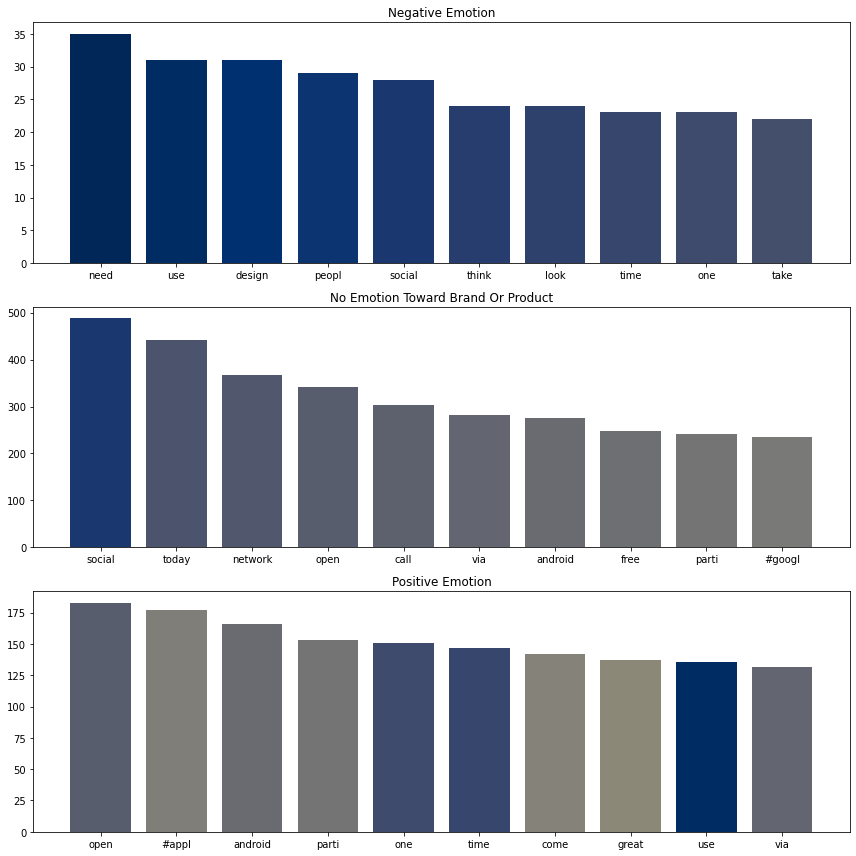

In [28]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Create a plot for each unique sentiment
data_by_sent = [y for _, y in sent_df.groupby('sentiment', as_index=False)]
for idx, group in enumerate(data_by_sent):
    # Find top 10 words in each sentiment
    all_words_in_sent = group.preprocessed_text.explode()
    top_10 = all_words_in_sent.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(group.iloc[0].sentiment.title())
    
fig.tight_layout()

Once all the actions above were completed, the data was ready for a train/test split in order to begin the modeling process.

In [29]:
# Convert token lists to strings
sent_df["joined_preprocessed_text"] = sent_df["preprocessed_text"].str.join(" ")

# Create train test split
X = sent_df['joined_preprocessed_text']
y = sent_df['sentiment']
# Explain zoom room 3 here
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333)

X_train

7817    everyon alreadi one anti theft protect leav la...
3158                             kick talk design headach
7555    frabjou day callooh callay baaah ûólewi carrol...
6829            umm would keep win shit thank killer case
3719                    design interfac navig schema #uxd
                              ...                        
5593    cameron sinclair spearhead japan disast relief...
7664                   #ipad therefor #appl near send pic
6173               crazi look around realiz last year one
987              nice outsid #appl guess peopl want ipad2
8310                              might well popup #ipad2
Name: joined_preprocessed_text, Length: 6702, dtype: object

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

The most dominant sentiment in the data is neutral, therefore we set our baseline accuracy as a model predicting neutral sentiment every time. This would result in an accuracy score of approximately 60%. 

In [30]:
# Setting baseline_accuracy equal to the normalized value_counts of neutral sentiment
baseline_accuracy = sent_df['sentiment'].value_counts(normalize=True)[0]
baseline_accuracy

0.6029543419874664

### First Model (Decision Tree)

Created a decision tree model with all default parameters. Our goal here was to purposefully create an overfit model in order to confirm it achieves a high accuracy score. Accomplishing this tells us we are using good enough data in order to predict our targe variable. 

In [31]:
# Creating steps for a Pipeline 
tree_steps = [('cv', CountVectorizer(stop_words='english')),
         ('tree', DecisionTreeClassifier())]
# Feeding the Pipeline the steps defined above
tree_pipe = Pipeline(tree_steps)
# Fitting the training data to the Pipeline
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('tree', DecisionTreeClassifier())])

This worked successfully, this model received an accuracy score of 95.17% on the training data.

In [32]:
# Defining the predictions from the Pipeline using the training data
y_pred = tree_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.9571769621008654

But, the cross_val_score is much lower (64%) showing this model is very overfit. This is still performing a little better than the baseline model.

In [35]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(tree_pipe, X_train, y_train, cv=5).mean()

0.649508386479237

### Second Model (Random Forest)

Created a Random Forest model with default parameters.

In [36]:
# Creating steps for a Pipeline 
forest_steps = [('cv', CountVectorizer(stop_words='english')),
         ('forest', RandomForestClassifier(random_state=333))]
# Feeding the Pipeline the steps defined above
forest_pipe = Pipeline(forest_steps)
# Fitting the training data to the Pipeline
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('forest', RandomForestClassifier(random_state=333))])

Again, this random forest model earned a high accuracy score on the training data but it is most likely due to overfitting.

In [37]:
# Defining the predictions from the Pipeline using the training data
y_pred = forest_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.9571769621008654

The cross validation score is a bit higher than it was for the decision tree model. This random forest model is still very overfit to the training data.

In [38]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(forest_pipe, X_train, y_train, cv=5).mean()

0.6809913519650073

### Random Forest with GridSearch

In order to combat the overfit results we used a GridSearch to help tune the hyperparameters.

In [39]:
# Creating parameters for GridSearch
params = {'forest__max_depth': [10, 100, None],
         'forest__max_features': [5, 50],
         'forest__n_estimators': [5, 10]}
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring='accuracy')
# Fitting the GridSearch
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('forest',
                                        RandomForestClassifier(random_state=333))]),
             param_grid={'forest__max_depth': [10, 100, None],
                         'forest__max_features': [5, 50],
                         'forest__n_estimators': [5, 10]},
             scoring='accuracy')

The GridSearch discovered max_depth=None, max_features=5, and n_estimators=10 had the best cross validation score. This is a worse score than the random forest model with default parameters.

In [40]:
# Displaying the best estimator from the GridSearch and the accuracy score
print(forest_grid.best_estimator_)
print(forest_grid.best_score_)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_features=5, n_estimators=10,
                                        random_state=333))])
0.667711331485748


### Updated Params (1st time)

Tried to improve results with new GridSearch.

In [42]:
# Creating parameters for GridSearch
params2 = {'forest__max_depth': [100, 300, None],
         'forest__max_features': [50, 75, 100],
         'forest__n_estimators': [10, 20, 30]}
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid2 = GridSearchCV(estimator=forest_pipe, param_grid=params2, cv=5, scoring='accuracy', verbose=3)
# Fitting the GridSearch
forest_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=10;, score=0.654 total time=   1.6s
[CV 2/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=10;, score=0.657 total time=   1.5s
[CV 3/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=10;, score=0.661 total time=   1.5s
[CV 4/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=10;, score=0.682 total time=   1.5s
[CV 5/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=10;, score=0.663 total time=   1.5s
[CV 1/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=20;, score=0.677 total time=   3.3s
[CV 2/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=20;, score=0.671 total time=   3.0s
[CV 3/5] END forest__max_depth=100, forest__max_features=50, forest__n_estimators=20;, score=0.672 total time=  

[CV 5/5] END forest__max_depth=300, forest__max_features=75, forest__n_estimators=20;, score=0.690 total time=   5.5s
[CV 1/5] END forest__max_depth=300, forest__max_features=75, forest__n_estimators=30;, score=0.671 total time=   8.5s
[CV 2/5] END forest__max_depth=300, forest__max_features=75, forest__n_estimators=30;, score=0.698 total time=   8.6s
[CV 3/5] END forest__max_depth=300, forest__max_features=75, forest__n_estimators=30;, score=0.669 total time=   8.1s
[CV 4/5] END forest__max_depth=300, forest__max_features=75, forest__n_estimators=30;, score=0.685 total time=   8.7s
[CV 5/5] END forest__max_depth=300, forest__max_features=75, forest__n_estimators=30;, score=0.687 total time=   8.4s
[CV 1/5] END forest__max_depth=300, forest__max_features=100, forest__n_estimators=10;, score=0.670 total time=   2.7s
[CV 2/5] END forest__max_depth=300, forest__max_features=100, forest__n_estimators=10;, score=0.678 total time=   2.6s
[CV 3/5] END forest__max_depth=300, forest__max_featur

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('forest',
                                        RandomForestClassifier(random_state=333))]),
             param_grid={'forest__max_depth': [100, 300, None],
                         'forest__max_features': [50, 75, 100],
                         'forest__n_estimators': [10, 20, 30]},
             scoring='accuracy', verbose=3)

The GridSearch discovered max_depth=300, max_features=75, and n_estimators=20 had the best cross validation score. This is right around the same score as the random forest model with default parameters.

In [43]:
# Displaying the best estimator from the GridSearch and the accuracy score
print(forest_grid2.best_estimator_)
print(forest_grid2.best_score_)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_depth=300, max_features=75,
                                        n_estimators=20, random_state=333))])
0.6845715494117777


### Updated Params (2nd time)

Tried to improve results with new GridSearch.

In [44]:
# Creating parameters for GridSearch
params3 = {'forest__max_depth': [300, 500, None],
         'forest__max_features': [60, 75, 90],
         'forest__n_estimators': [30, 50, 70]}
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid3 = GridSearchCV(estimator=forest_pipe, param_grid=params3, cv=5, scoring='accuracy', verbose=2)
# Fitting the GridSearch
forest_grid3.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=30; total time=   8.5s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=30; total time=   8.5s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=30; total time=   8.4s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=30; total time=   8.8s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=30; total time=   8.5s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=50; total time=  14.5s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=50; total time=  14.5s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=50; total time=  14.2s
[CV] END forest__max_depth=300, forest__max_features=60, forest__n_estimators=50; total time=  14.6s
[CV] END forest__max_depth=30

[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=50; total time=  18.5s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=50; total time=  17.6s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=50; total time=  18.3s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=50; total time=  18.1s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=70; total time=  25.1s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=70; total time=  26.0s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=70; total time=  24.7s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=70; total time=  25.3s
[CV] END forest__max_depth=500, forest__max_features=90, forest__n_estimators=70; total time=  25.2s
[CV] END forest__max_depth=None, forest__max_features=60, forest__n_estimators=30; total ti

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('forest',
                                        RandomForestClassifier(random_state=333))]),
             param_grid={'forest__max_depth': [300, 500, None],
                         'forest__max_features': [60, 75, 90],
                         'forest__n_estimators': [30, 50, 70]},
             scoring='accuracy', verbose=2)

The GridSearch discovered max_depth=300, max_features=90, and n_estimators=70 had the best cross validation score. This improvement was minimal from the previous GridSearch iteration so we decided to move on to a new model.

In [45]:
# Displaying the best estimator from the GridSearch and the accuracy score
print(forest_grid3.best_estimator_)
print(forest_grid3.best_score_)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('forest',
                 RandomForestClassifier(max_depth=300, max_features=90,
                                        n_estimators=70, random_state=333))])
0.6877062116709517


### Third Model (Logistic Regression)

Created a logistic regression model with an awareness that logistic regression does not handle class imbalances as well as decision trees/random forests.

In [59]:
# Creating steps for a Pipeline 
logreg_steps = [('cv', CountVectorizer(stop_words='english')),
         ('logreg', LogisticRegression(random_state=333, max_iter=1000))]
# Feeding the Pipeline the steps defined above
logreg_pipe = Pipeline(logreg_steps)
# Fitting the training data to the Pipeline
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('logreg',
                 LogisticRegression(max_iter=1000, random_state=333))])

This logistic regression has an 88% accuracy score which is pretty high but it could be overfit to the training data and probably isn't doing well with the class imbalance.

In [60]:
# Defining the predictions from the Pipeline using the training data
y_pred = logreg_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.8836168307967771

Created confusion matrix in order to investigate how the model is handling the class imbalance. It shows that this model is struggling predicting the negative and positive sentiments accurately but is doing pretty well with the neutral sentiment becuase most of the data is neutral. 

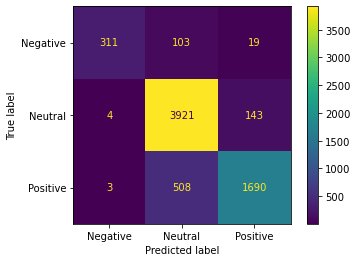

In [61]:
cf = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(cf, display_labels=['Negative', 'Neutral', 'Positive']).plot()

Compared the training results to a cross validation score. This shows the model is also very overfit because of the much lower cross validation score.

In [62]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(logreg_pipe, X_train, y_train, cv=5).mean()

0.6883016683918216

### Logistic Regression with GridSearch

In order to combat the poor performance due to overfitting and the class imbalance, we used a GridSearch to help tune the hyperparameters.

In [66]:
# Creating parameters for GridSearch
logreg_params = {'logreg__class_weight':[None,'balanced', [4, 1, 2]],
                'logreg__C': [0.1, 1, 10, 100],
                'logreg__solver': ['lbfgs', 'sag', 'newton-cg', 'saga'],
                'logreg__max_iter': [5000]}
# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
logreg_grid = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_params, cv=5, scoring='accuracy', verbose=3)
# Fitting the GridSearch
logreg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=lbfgs;, score=0.676 total time=   0.1s
[CV 2/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=lbfgs;, score=0.682 total time=   0.1s
[CV 3/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=lbfgs;, score=0.676 total time=   0.1s
[CV 4/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=lbfgs;, score=0.684 total time=   0.1s
[CV 5/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=lbfgs;, score=0.684 total time=   0.2s
[CV 1/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=sag;, score=0.676 total time=   0.1s
[CV 2/5] END logreg__C=0.1, logreg__class_weight=None, logreg__max_iter=5000, logreg__solver=sag;, score=0.682 total time=   0.0s
[CV 3/5] END logre

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.611 total time=   7.9s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.638 total time=   7.9s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.622 total time=   8.1s
[CV 4/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.629 total time=   7.4s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.629 total time=   8.0s
[CV 1/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.610 total time=   0.2s
[CV 2/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.640 total time=   0.2s
[CV 3/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.624 total time=   0.2s
[CV 4/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.629 total time=   0.2s
[CV 5/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.633 total time=   0.2s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.606 total time=   8.9s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.651 total time=   8.6s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.622 total time=   8.7s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.628 total time=   8.7s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=0.1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.631 total time=   8.7s
[CV 1/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=sag;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=0.1, logreg__class_weight=[4, 1, 2

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.637 total time=   7.9s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.668 total time=   7.9s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.643 total time=   8.1s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.653 total time=   8.1s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=sag;, score=0.646 total time=   7.9s
[CV 1/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.641 total time=   0.2s
[CV 2/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.665 total time=   0.2s
[CV 3/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.645 total time=   0.2s
[CV 4/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.654 total time=   0.2s
[CV 5/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=newton-cg;, score=0.649 total time=   0.2s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.640 total time=   8.4s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.665 total time=   8.3s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.646 total time=   8.4s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.657 total time=   8.4s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=1, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.649 total time=   8.4s
[CV 1/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=sag;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=1, logreg__class_weight=[4, 1, 2], logreg__max_i

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=10, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.633 total time=   9.0s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=10, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.647 total time=   9.1s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=10, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.634 total time=   9.4s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=10, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.660 total time=   9.1s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=10, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.649 total time=   8.7s
[CV 1/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=sag;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=10, logreg__class_weight=[4, 1, 2], logre

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=100, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.623 total time=   8.8s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=100, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.640 total time=   8.6s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=100, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.607 total time=   8.4s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=100, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.643 total time=   8.6s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=100, logreg__class_weight=balanced, logreg__max_iter=5000, logreg__solver=saga;, score=0.639 total time=   8.7s
[CV 1/5] END logreg__C=100, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=100, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END logreg__C=100, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END logreg__C=100, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END logreg__C=100, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END logreg__C=100, logreg__class_weight=[4, 1, 2], logreg__max_iter=5000, logreg__solver=sag;, score=nan total time=   0.0s
[CV 2/5] END logreg__C=100, logreg__class_weight=[4, 1, 2

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_es

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=333))]),
             param_grid={'logreg__C': [0.1, 1, 10, 100],
                         'logreg__class_weight': [None, 'balanced', [4, 1, 2]],
                         'logreg__max_iter': [5000],
                         'logreg__solver': ['lbfgs', 'sag', 'newton-cg',
                                            'saga']},
             scoring='accuracy', verbose=3)

The GridSearch discovered C=1, max_iter=5000, default weights, and solver='saga' had the best cross validation score. This is a marginal improvement from our logistic regression with all default settings. Throughout the GridSearch, sometimes the max iterations was reached without the model converging. This model did not have the problem and the results can be trusted.

In [67]:
print(logreg_grid.best_estimator_)
print(logreg_grid.best_score_)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('logreg',
                 LogisticRegression(C=1, max_iter=5000, random_state=333,
                                    solver='saga'))])
0.6888984607165515


### Fourth Model (Multinomial Naive Bayes)

Created a Multinomial Naive Bayes (MNB) model.

In [68]:
# Creating steps for a Pipeline 
mnb_steps = [('tfidf', TfidfVectorizer()),
             ('mnb', MultinomialNB())]
# Feeding the Pipeline the steps defined above
mnb_pipe = Pipeline(mnb_steps)
# Fitting the training data to the Pipeline
mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

This was a lower accuracy score on the training data than on previous models that sparked hope it was not overfit.

In [69]:
# Defining the predictions from the Pipeline using the training data
y_pred = mnb_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
accuracy_score(y_train, y_pred)

0.7593255744553864

This was a pretty low cross validation score and is in line with our previous models. It seemed to be a little less overfit than the previous models but, still is very overfit on the training data.

In [70]:
# Calculating mean of the 5-fold cross_val_score
cross_val_score(mnb_pipe, X_train, y_train, cv=5).mean()

0.6674115997195231

### MNB with GridSearch

Tried to improve the MNB model by adjusting hyperparameters using a GridSearch.

In [73]:
# Creating parameters for GridSearch
mnb_params = {'mnb__alpha':[1, 0.5, 0],
          'mnb__fit_prior':[True, False]}
# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
mnb_grid = GridSearchCV(estimator=mnb_pipe, param_grid=mnb_params, cv=5, scoring='accuracy', verbose=3)
# Fitting the GridSearch
mnb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .mnb__alpha=1, mnb__fit_prior=True;, score=0.672 total time=   0.0s
[CV 2/5] END .mnb__alpha=1, mnb__fit_prior=True;, score=0.670 total time=   0.0s
[CV 3/5] END .mnb__alpha=1, mnb__fit_prior=True;, score=0.663 total time=   0.0s
[CV 4/5] END .mnb__alpha=1, mnb__fit_prior=True;, score=0.669 total time=   0.0s
[CV 5/5] END .mnb__alpha=1, mnb__fit_prior=True;, score=0.663 total time=   0.0s
[CV 1/5] END mnb__alpha=1, mnb__fit_prior=False;, score=0.652 total time=   0.0s
[CV 2/5] END mnb__alpha=1, mnb__fit_prior=False;, score=0.662 total time=   0.0s
[CV 3/5] END mnb__alpha=1, mnb__fit_prior=False;, score=0.643 total time=   0.0s
[CV 4/5] END mnb__alpha=1, mnb__fit_prior=False;, score=0.649 total time=   0.0s
[CV 5/5] END mnb__alpha=1, mnb__fit_prior=False;, score=0.666 total time=   0.0s
[CV 1/5] END mnb__alpha=0.5, mnb__fit_prior=True;, score=0.667 total time=   0.0s
[CV 2/5] END mnb__alpha=0.5, mnb__fit_prior=True

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\42ben\anaconda3\e

[CV 1/5] END .mnb__alpha=0, mnb__fit_prior=True;, score=0.655 total time=   0.0s
[CV 2/5] END .mnb__alpha=0, mnb__fit_prior=True;, score=0.660 total time=   0.0s
[CV 3/5] END .mnb__alpha=0, mnb__fit_prior=True;, score=0.666 total time=   0.0s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\42ben\anaconda3\e

[CV 4/5] END .mnb__alpha=0, mnb__fit_prior=True;, score=0.648 total time=   0.0s
[CV 5/5] END .mnb__alpha=0, mnb__fit_prior=True;, score=0.672 total time=   0.0s
[CV 1/5] END mnb__alpha=0, mnb__fit_prior=False;, score=0.587 total time=   0.0s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\42ben\anaconda3\e

[CV 2/5] END mnb__alpha=0, mnb__fit_prior=False;, score=0.614 total time=   0.0s
[CV 3/5] END mnb__alpha=0, mnb__fit_prior=False;, score=0.608 total time=   0.0s
[CV 4/5] END mnb__alpha=0, mnb__fit_prior=False;, score=0.599 total time=   0.0s
[CV 5/5] END mnb__alpha=0, mnb__fit_prior=False;, score=0.620 total time=   0.0s


C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [1, 0.5, 0],
                         'mnb__fit_prior': [True, False]},
             scoring='accuracy', verbose=3)

This did not improve much from the accuracy score using the defualt parameters but, it did improve about 0.5%.

In [75]:
print(mnb_grid.best_estimator_)
print(mnb_grid.best_score_)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('mnb', MultinomialNB(alpha=0.5))])
0.6720380201898783


### Stacking Random Forest, Logistic Regression, and MNB Models

Attempted to make an improved model by stacking the other models together.

In [76]:
# Defining the estimators to feed the stacked classifier
estimators = [('forest', RandomForestClassifier(random_state=333)),
 ('logreg', LogisticRegression(random_state=333)),
 ('mnb', MultinomialNB())]

In [83]:
# Feeding the estimators to teh stacking classifier
sc = StackingClassifier(estimators=estimators)
# Instantiating standard scaler
scaler = StandardScaler(with_mean=False)

# Creating stacking classifier Pipeline
sc_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()),
                          ('scaler', scaler),
                          ('sc', sc)])

In [84]:
sc_pipe.fit(X_train, y_train)

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('sc',
                 StackingClassifier(estimators=[('forest',
                                                 RandomForestClassifier(random_state=333)),
                                                ('logreg',
                                                 LogisticRegression(random_state=333)),
                                                ('mnb', MultinomialNB())]))])

In [87]:
y_pred = sc_pipe.predict(X_train)
accuracy_score(y_train, y_pred)

0.9580722172485825

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
